In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load our 100% clean data
df = pd.read_parquet('/content/asteroid_cleaned.parquet')

print("Cleaned data loaded successfully.")
df.info()

Cleaned data loaded successfully.
<class 'pandas.core.frame.DataFrame'>
Index: 823259 entries, 0 to 839713
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   a               823259 non-null  float64
 1   e               823259 non-null  float64
 2   i               823259 non-null  float64
 3   om              823259 non-null  float64
 4   w               823259 non-null  float64
 5   q               823259 non-null  float64
 6   ad              823259 non-null  float64
 7   per_y           823259 non-null  float64
 8   data_arc        823259 non-null  float64
 9   condition_code  823259 non-null  int64  
 10  n_obs_used      823259 non-null  int64  
 11  H               823259 non-null  float64
 12  neo             823259 non-null  int64  
 13  pha             823259 non-null  int64  
 14  moid            823259 non-null  float64
 15  n               823259 non-null  float64
 16  per             823259 non-

In [3]:
# Define our features (X) and target (y)
# X is everything *except* our 'pha' target column
X = df.drop('pha', axis=1)
y = df['pha']

print(f"Features shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")

Features shape (X): (823259, 29)
Target shape (y): (823259,)


In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Verify the stratification
print(f"\nProportion of PHAs in y_train: {y_train.mean():.4f}")
print(f"Proportion of PHAs in y_test: {y_test.mean():.4f}")

Training data shape: (658607, 29)
Testing data shape: (164652, 29)

Proportion of PHAs in y_train: 0.0024
Proportion of PHAs in y_test: 0.0024


In [5]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the *same* scaler
X_test_scaled = scaler.transform(X_test)

print("\nData has been scaled.")


Data has been scaled.


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Initialize the model
baseline_model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

# 2. Train the model on the *scaled* training data
print("Training baseline model...")
baseline_model.fit(X_train_scaled, y_train)
print("Training complete.")

# 3. Make predictions on the *scaled* test set
y_pred_baseline = baseline_model.predict(X_test_scaled)

# 4. Evaluate the model with the Classification Report
print("\n--- Baseline Model Classification Report ---")
print(classification_report(y_test, y_pred_baseline, target_names=['Non-Hazardous (0)', 'Hazardous (1)']))

Training baseline model...
Training complete.

--- Baseline Model Classification Report ---
                   precision    recall  f1-score   support

Non-Hazardous (0)       1.00      0.99      1.00    164249
    Hazardous (1)       0.23      1.00      0.37       403

         accuracy                           0.99    164652
        macro avg       0.61      1.00      0.68    164652
     weighted avg       1.00      0.99      0.99    164652




--- Baseline Model Confusion Matrix ---


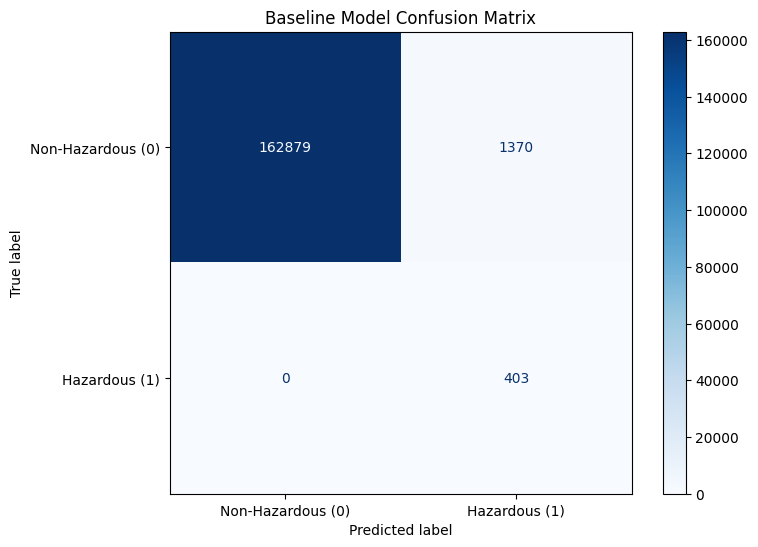

In [7]:
# 5. Plot the confusion matrix
print("\n--- Baseline Model Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Hazardous (0)', 'Hazardous (1)'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Baseline Model Confusion Matrix")
plt.show()

In [8]:
# Install the library for handling imbalanced data
!pip install imbalanced-learn

In [9]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# 1. Define the steps for our pipeline
# Step 1: Resample the data with SMOTE
# Step 2: Train the advanced XGBoost classifier
model_xgb = XGBClassifier(random_state=42)
smote = SMOTE(random_state=42)

steps = [
    ('smote', smote),
    ('model', model_xgb)
]

# 2. Create the pipeline
xgb_pipeline = Pipeline(steps)

# 3. Train the new model
# We use the *scaled* training data from Phase 3
print("Training advanced XGBoost model with SMOTE...")
# This will take longer than the simple model
xgb_pipeline.fit(X_train_scaled, y_train)
print("Training complete.")

# 4. Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test_scaled)

# 5. Evaluate the advanced model
print("\n--- Advanced XGBoost + SMOTE Model Report ---")
print(classification_report(y_test, y_pred_xgb, target_names=['Non-Hazardous (0)', 'Hazardous (1)']))

Training advanced XGBoost model with SMOTE...
Training complete.

--- Advanced XGBoost + SMOTE Model Report ---
                   precision    recall  f1-score   support

Non-Hazardous (0)       1.00      1.00      1.00    164249
    Hazardous (1)       0.98      0.98      0.98       403

         accuracy                           1.00    164652
        macro avg       0.99      0.99      0.99    164652
     weighted avg       1.00      1.00      1.00    164652




--- Advanced Model Confusion Matrix ---


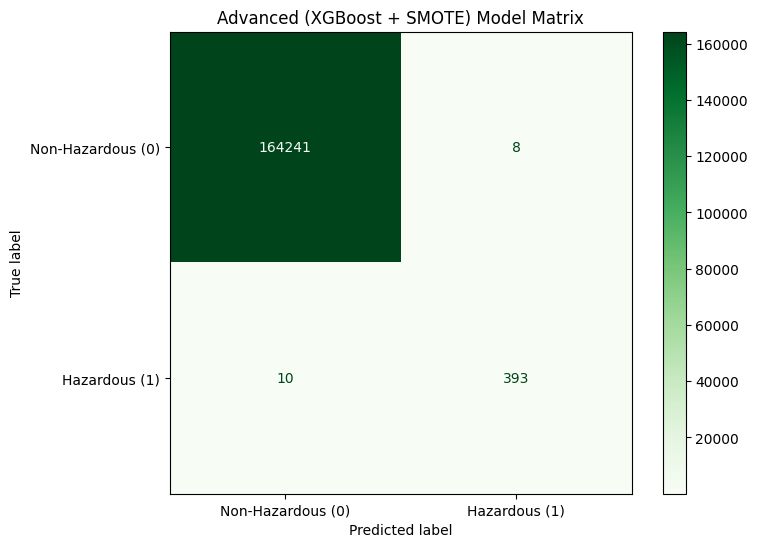

In [10]:
# 6. Plot the new confusion matrix
print("\n--- Advanced Model Confusion Matrix ---")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Non-Hazardous (0)', 'Hazardous (1)'])

fig, ax = plt.subplots(figsize=(8, 6))
disp_xgb.plot(ax=ax, cmap=plt.cm.Greens)
plt.title("Advanced (XGBoost + SMOTE) Model Matrix")
plt.show()

--- Top 20 Most Important Features ---
           feature  importance
13            moid    0.962900
11               H    0.016759
17       class_AMO    0.014110
5                q    0.002146
8         data_arc    0.000948
0                a    0.000654
7            per_y    0.000468
2                i    0.000341
4                w    0.000326
10      n_obs_used    0.000305
16              ma    0.000299
9   condition_code    0.000270
6               ad    0.000158
3               om    0.000140
14               n    0.000088
1                e    0.000082
18       class_APO    0.000007
12             neo    0.000000
15             per    0.000000
19       class_AST    0.000000


/tmp/ipython-input-1406719519.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


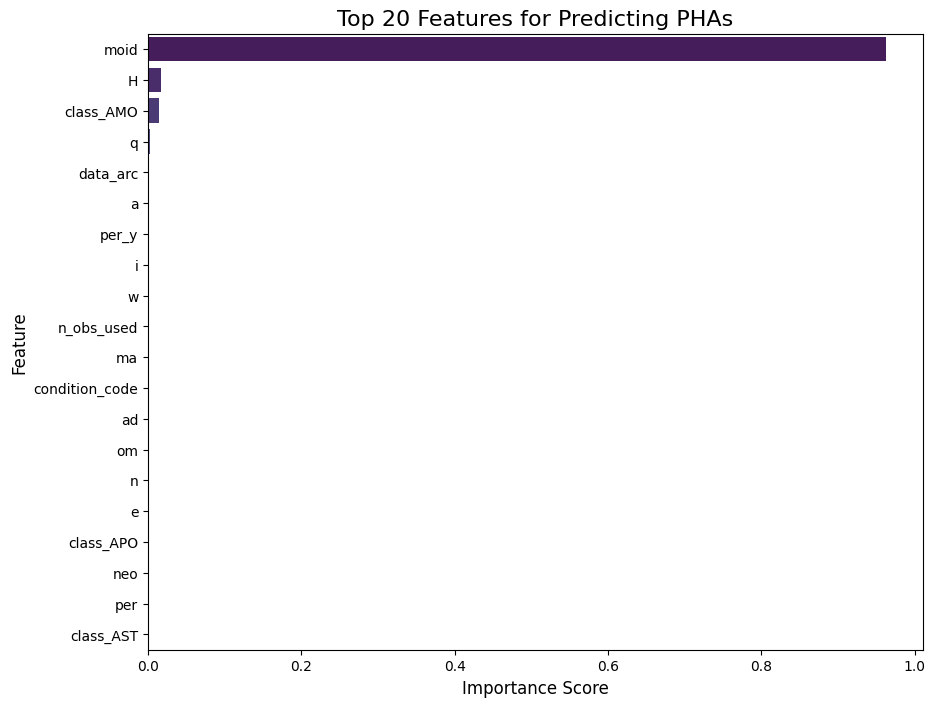

In [11]:
# 1. Extract the trained XGBoost model from our pipeline
xgb_model = xgb_pipeline.named_steps['model']

# 2. Get the feature importances
importances = xgb_model.feature_importances_

# 3. Get the feature names
# We need to get the column names from our original features 'X'
feature_names = X.columns

# 4. Create a DataFrame to view them
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("--- Top 20 Most Important Features ---")
print(importance_df.head(20))

# 5. Plot the top features
plt.figure(figsize=(10, 8))
sns.barplot(
    x='importance',
    y='feature',
    data=importance_df.head(20),
    palette='viridis'
)
plt.title('Top 20 Features for Predicting PHAs', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

In [12]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# --- 1. Re-create our full (unsplit) X and y ---
X = df.drop('pha', axis=1)
y = df['pha']

# --- 2. Create the full pipeline *with the scaler inside it* ---
# This is crucial for cross-validation
full_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(random_state=42))
])

# --- 3. Set up the Cross-Validation ---
# We use 'Stratified' K-Folds to ensure each fold gets
# the same tiny % of hazardous asteroids
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 4. Run the Cross-Validation ---
# We care about 'recall_macro' and 'precision_macro'
# 'macro' means it averages the scores for both classes,
# which is good for imbalanced data.
scoring_metrics = ['recall_macro', 'precision_macro', 'f1_macro']

print("\nStarting Cross-Validation (this will take a few minutes)...")
cv_results = cross_validate(full_pipeline, X, y, cv=kfold, scoring=scoring_metrics)
print("Cross-Validation complete.")

# --- 5. Show the Results ---
print("\n--- Cross-Validation Results (5 Folds) ---")
print(f"Average Precision (macro): {cv_results['test_precision_macro'].mean():.4f}")
print(f"Average Recall (macro):    {cv_results['test_recall_macro'].mean():.4f}")
print(f"Average F1-Score (macro):  {cv_results['test_f1_macro'].mean():.4f}")

print("\n--- Scores for each fold ---")
print(f"Precision scores: {cv_results['test_precision_macro']}")
print(f"Recall scores:    {cv_results['test_recall_macro']}")


Starting Cross-Validation (this will take a few minutes)...
Cross-Validation complete.

--- Cross-Validation Results (5 Folds) ---
Average Precision (macro): 0.9825
Average Recall (macro):    0.9863
Average F1-Score (macro):  0.9844

--- Scores for each fold ---
Precision scores: [0.98383139 0.98015236 0.98523363 0.97575648 0.98759636]
Recall scores:    [0.98383139 0.98134087 0.99003791 0.98753217 0.98880331]
